In [1]:
import numpy as np
import h5py
import glob, os, re, sys
import pickle
from pathlib import Path
sys.path.append('../')

import pandas as pd

import astro_helper as ah
import configparser
config = configparser.ConfigParser()
config.read('../config_allgas.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

# weight

In [68]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'NGC300', 'MW']
tagdirs = [Path(config[tag]['SAVE_DIR']) / Path(config[tag]['SUBDIR']) for tag in tags]
xymaxs = [config[tag].getfloat('XYMAX') for tag in tags] # kpc
xybinwidths = [config[tag].getfloat('XYBINWIDTH') for tag in tags] # pc
xybinnos = [int(np.rint(2.*xymax * ah.kpc_to_cm / (xybinwidth * ah.pc_to_cm))) for xymax, xybinwidth in zip(xymaxs, xybinwidths)]

In [69]:
# create x, y and R grids for each tag
xgrids, ygrids, Rgrids = [], [], []
for tagdir, xymax, xybinno in zip(tagdirs, xymaxs, xybinnos):
    x_edges = np.linspace(-xymax*ah.kpc_to_cm, xymax*ah.kpc_to_cm, xybinno+1)
    y_edges = np.linspace(-xymax*ah.kpc_to_cm, xymax*ah.kpc_to_cm, xybinno+1)
    x = 0.5 * (x_edges[:-1] + x_edges[1:])
    y = 0.5 * (y_edges[:-1] + y_edges[1:])
    xgrid, ygrid = np.meshgrid(x, y)
    Rgrid = np.sqrt(xgrid**2 + ygrid**2)
    xgrids.append(xgrid)
    ygrids.append(ygrid)
    Rgrids.append(Rgrid)

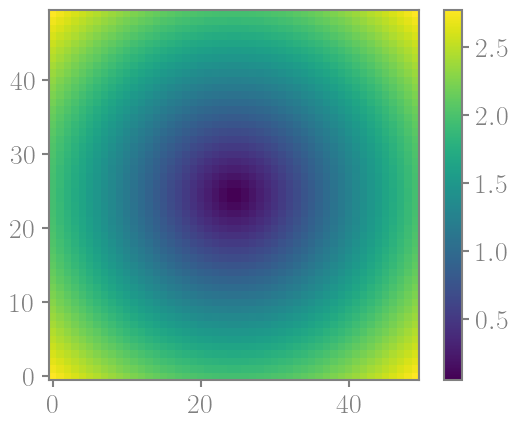

In [70]:
plt.imshow(Rgrids[0]/ah.kpc_to_cm, origin='lower')
plt.colorbar()
plt.show()

In [71]:
alldata = {
    'galaxy': [],
    'weight': [],
    'rotcurve': [],
    'kappa': [],
    'gas_surfdens': [],
    'gas_surfdens_cw': [],
    'star_surfdens': [],
    'SFR_surfdens': [],
    'dm_voldens': [],
    'gas_voldens': [],
    'star_voldens': [],
    'H2_mass': [],
    'HI_mass': [],
    'H2HI_mass': [],
    'gas_voldens_midplane': [],
    'gas_voldens_midplane_cw': [],
    'star_voldens_midplane': [],
    'veldisp_midplane': [],
    'Pturb': [],
    'Ptherm': [],
    'R/Router': [],
    #'time': [], ? I'm not sure what reference time to use here, think about this
}

for tag, tagdir, Rgrid, xymax in zip(tags, tagdirs, Rgrids, xymaxs):
    # weights from Forces
    arrays = glob.glob(str(tagdir) + "/Forces_*.pkl")
    arraynos = [int(array.rsplit('Forces_')[1].rsplit('_'+tag)[0]) for array in arrays]
    arrays = [array for _, array in sorted(zip(arraynos, arrays))]
    print(arrays)
    for array in arrays:
        with open(array, "rb") as f:
            props_dict = pickle.load(f)
        Rgrid_3d = np.repeat(Rgrid[:, :, np.newaxis], props_dict['weight'].shape[2], axis=2) # repeat Rgrid along time axis
        cnd_R = (Rgrid_3d <= xymax*ah.kpc_to_cm)
        alldata['weight'].extend(list(np.ravel(props_dict['weight'][cnd_R])))
        alldata['R/Router'].extend(list(np.ravel(Rgrid_3d[cnd_R]/(xymax*ah.kpc_to_cm)))) # ensure same number of repetitions
        alldata['galaxy'].extend([tag]*np.ravel(Rgrid_3d[cnd_R]).size) # galaxy names

    # all-gas properties
    arrays = glob.glob(str(tagdir) + "/allgas_*.pkl")
    arraynos = [int(array.rsplit('allgas_')[1].rsplit('_'+tag)[0]) for array in arrays]
    arrays = [array for _, array in sorted(zip(arraynos, arrays))]
    print(arrays)
    for array in arrays:
        with open(array, "rb") as f:
            props_dict = pickle.load(f)
        Rgrid_3d = np.repeat(Rgrid[:, :, np.newaxis], props_dict['rotcurve'].shape[2], axis=2) # repeat Rgrid along time axis
        cnd_R = (Rgrid_3d <= xymax*ah.kpc_to_cm)
        alldata['rotcurve'].extend(list(np.ravel(props_dict['rotcurve'][cnd_R])))
        alldata['kappa'].extend(list(np.ravel(props_dict['kappa'][cnd_R])))
        alldata['SFR_surfdens'].extend(list(np.ravel(props_dict['SFR_surfdens'][cnd_R])))
        alldata['H2_mass'].extend(list(np.ravel(props_dict['H2_frac'][cnd_R] * props_dict['gas_surfdens'][cnd_R])))
        alldata['HI_mass'].extend(list(np.ravel(props_dict['HI_frac'][cnd_R] * props_dict['gas_surfdens'][cnd_R])))
        alldata['H2HI_mass'].extend(list(np.ravel((props_dict['H2_frac'][cnd_R] + props_dict['HI_frac'][cnd_R]) * props_dict['gas_surfdens'][cnd_R])))
        alldata['gas_surfdens'].extend(list(np.ravel(props_dict['gas_surfdens'][cnd_R])))
        alldata['star_surfdens'].extend(list(np.ravel(props_dict['star_surfdens'][cnd_R])))
        alldata['gas_voldens_midplane'].extend(list(np.ravel(props_dict['gas_voldens_midplane'][cnd_R])))
        alldata['star_voldens_midplane'].extend(list(np.ravel(props_dict['star_voldens_midplane'][cnd_R])))

    # cool-warm gas properties
    arrays = glob.glob(str(tagdir) + "/coolgas_*.pkl")
    arraynos = [int(array.rsplit('coolgas_')[1].rsplit('_'+tag)[0]) for array in arrays]
    arrays = [array for _, array in sorted(zip(arraynos, arrays))]
    print(arrays)
    for array in arrays:
        with open(array, "rb") as f:
            props_dict = pickle.load(f)
        Rgrid_3d = np.repeat(Rgrid[:, :, np.newaxis], props_dict['gas_surfdens'].shape[2], axis=2) # repeat Rgrid along time axis
        cnd_R = (Rgrid_3d <= xymax*ah.kpc_to_cm)
        alldata['gas_surfdens_cw'].extend(list(np.ravel(props_dict['gas_surfdens'][cnd_R])))
        alldata['gas_voldens_midplane_cw'].extend(list(np.ravel(props_dict['gas_voldens_midplane'][cnd_R])))
        alldata['veldisp_midplane'].extend(list(np.ravel(props_dict['veldisp_midplane'][cnd_R])))
        alldata['Pturb'].extend(list(np.ravel(props_dict['Pturb'][cnd_R])))
        alldata['Ptherm'].extend(list(np.ravel(props_dict['Ptherm'][cnd_R])))

    # dark matter and gas volume densities
    arrays = glob.glob(str(tagdir) + "/voldens_*.pkl")
    arraynos = [int(array.rsplit('voldens_')[1].rsplit('_'+tag)[0]) for array in arrays]
    arrays = [array for _, array in sorted(zip(arraynos, arrays))]
    print(arrays)
    for array in arrays:
        with open(array, "rb") as f:
            props_dict = pickle.load(f)
        Rgrid_3d = np.repeat(Rgrid[:, :, np.newaxis], props_dict['dm_voldens'].shape[2], axis=2)
        cnd_R = (Rgrid_3d <= xymax*ah.kpc_to_cm)
        alldata['dm_voldens'].extend(list(np.ravel(props_dict['dm_voldens'][cnd_R])))
        alldata['gas_voldens'].extend(list(np.ravel(props_dict['gas_voldens'][cnd_R])))

    # star volume densities
    arrays = glob.glob(str(tagdir) + "/star_voldens_*.pkl")
    arraynos = [int(array.rsplit('star_voldens_')[1].rsplit('_'+tag)[0]) for array in arrays]
    arrays = [array for _, array in sorted(zip(arraynos, arrays))]
    print(arrays)
    for array in arrays:
        with open(array, "rb") as f:
            props_dict = pickle.load(f)
        Rgrid_3d = np.repeat(Rgrid[:, :, np.newaxis], props_dict['star_voldens'].shape[2], axis=2)
        cnd_R = (Rgrid_3d <= xymax*ah.kpc_to_cm)
        alldata['star_voldens'].extend(list(np.ravel(props_dict['star_voldens'][cnd_R])))

['/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_124_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_149_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_174_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_199_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_224_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_249_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_274_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_299_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/vlM-output/Forces_324_ETG-vlM_T2.0e+04_avir2.0e+00.pkl', '/n/holystore01/LABS/itc_la

In [72]:
print([key for key in alldata.keys()])
print([len(val) for key, val in alldata.items()])

['galaxy', 'weight', 'rotcurve', 'kappa', 'gas_surfdens', 'gas_surfdens_cw', 'star_surfdens', 'SFR_surfdens', 'dm_voldens', 'gas_voldens', 'star_voldens', 'H2_mass', 'HI_mass', 'H2HI_mass', 'gas_voldens_midplane', 'gas_voldens_midplane_cw', 'star_voldens_midplane', 'veldisp_midplane', 'Pturb', 'Ptherm', 'R/Router']
[3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496, 3251496]


In [73]:
df = pd.DataFrame(alldata)

Number of NaN rotcurve elements: 4
Number of NaN kappa elements: 906


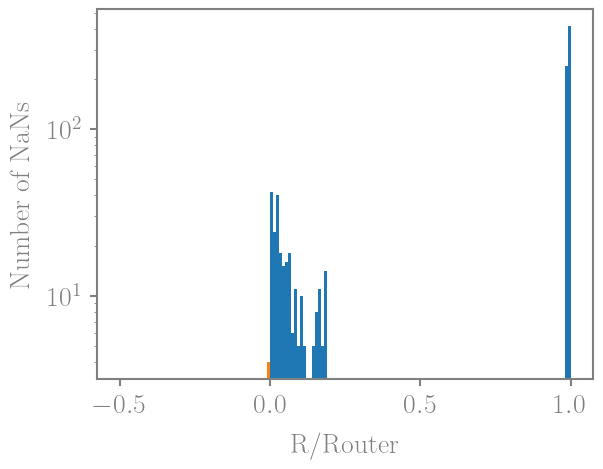

In [74]:
# we only want to calculate properties for the 'cool-warm' ISM as can be defined
# in cosmological volume simulations, < 0.13 H/cc and < 20,000K
df_filtered = df[df['gas_voldens']/ah.mp_cgs/ah.mu > 0.13]

# if cool-warm mid-plane volume density is 0, set Pturb and veldisp to 0 (currently NaN,
# but zero makes more sense)
df_filtered.loc[df_filtered['gas_voldens_midplane_cw'] == 0, 'Pturb'] = 0
df_filtered.loc[df_filtered['gas_voldens_midplane_cw'] == 0, 'veldisp_midplane'] = 0

# set all remaining NaN in Pturb and veldisp to zero, because it just means there are too
# few cool-warm particles
df_filtered.loc[df_filtered['Pturb'].isna(), 'Pturb'] = 0
df_filtered.loc[df_filtered['veldisp_midplane'].isna(), 'veldisp_midplane'] = 0

# if cool-warm mid-plane volume density is NaN, set it to zero, along with Pturb, veldisp and Ptherm
df_filtered.loc[df_filtered['gas_voldens_midplane_cw'].isna(), 'Pturb'] = 0
df_filtered.loc[df_filtered['gas_voldens_midplane_cw'].isna(), 'veldisp_midplane'] = 0
df_filtered.loc[df_filtered['gas_voldens_midplane_cw'].isna(), 'Ptherm'] = 0
df_filtered.loc[df_filtered['gas_voldens_midplane_cw'].isna(), 'gas_voldens_midplane_cw'] = 0

# if star voldens at the mid-plane is NaN, it is just zero
df_filtered.loc[df_filtered['star_voldens_midplane'].isna(), 'star_voldens_midplane'] = 0

# exclude values with rotcurve or kappa is NaN, and print the number of such elements (should be
# small and just at the disk outskirts due to edge-effects)
print('Number of NaN rotcurve elements:', df_filtered['rotcurve'].isna().sum())
print('Number of NaN kappa elements:', df_filtered['kappa'].isna().sum())

# plot the R values where kappa is NaN
plt.hist(df_filtered['R/Router'][df_filtered['kappa'].isna()], bins=100, log=True)
plt.hist(df_filtered['R/Router'][df_filtered['rotcurve'].isna()], bins=100, log=True)
plt.xlabel('R/Router')
plt.ylabel('Number of NaNs')
plt.show()

df_filtered = df_filtered.dropna(subset=['rotcurve', 'kappa'])

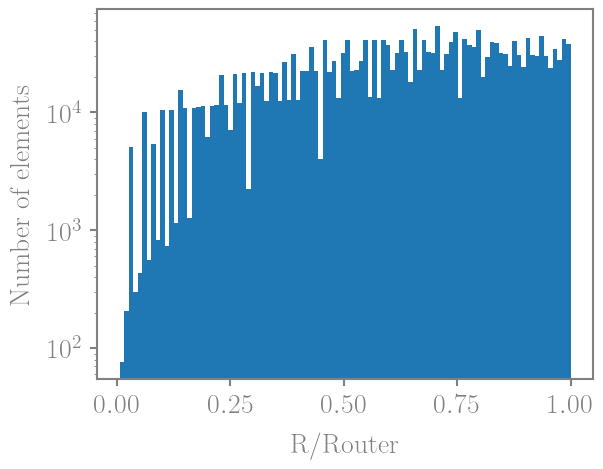

In [75]:
# plot a histogram of all R/Router values
plt.hist(df_filtered['R/Router'], bins=100, log=True)
plt.xlabel('R/Router')
plt.ylabel('Number of elements')
plt.show()

In [76]:
nan_counts = df_filtered.isna().sum()
total_counts = df_filtered.count()
print(nan_counts)
print(total_counts)

galaxy                     0
weight                     0
rotcurve                   0
kappa                      0
gas_surfdens               0
gas_surfdens_cw            0
star_surfdens              0
SFR_surfdens               0
dm_voldens                 0
gas_voldens                0
star_voldens               0
H2_mass                    0
HI_mass                    0
H2HI_mass                  0
gas_voldens_midplane       0
gas_voldens_midplane_cw    0
star_voldens_midplane      0
veldisp_midplane           0
Pturb                      0
Ptherm                     0
R/Router                   0
dtype: int64
galaxy                     2346184
weight                     2346184
rotcurve                   2346184
kappa                      2346184
gas_surfdens               2346184
gas_surfdens_cw            2346184
star_surfdens              2346184
SFR_surfdens               2346184
dm_voldens                 2346184
gas_voldens                2346184
star_voldens               2

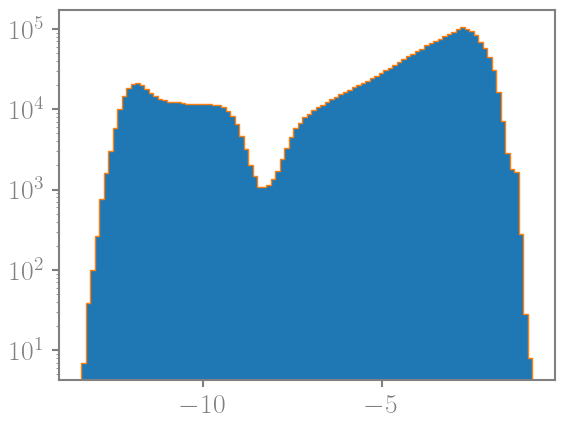

In [77]:
plt.hist(np.log10((df_filtered['H2HI_mass']-df_filtered['HI_mass'])+1.e-50), bins=100, log=True)
plt.hist(np.log10((df_filtered['H2_mass'])+1.e-50), bins=100, log=True, histtype='step')
plt.show()

In [79]:
# randomly-sample an equal number of data points from each galaxy type
# the sample size is equal to the number of datapoints for the galaxy with the smallest number of datapoints
sample_size = df_filtered.groupby('galaxy').size().min()
df_sampled = df_filtered.groupby('galaxy').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)

nan_counts = df_sampled.isna().sum()
total_counts = df_sampled.count()
print(nan_counts)
print(total_counts)

galaxy                     0
weight                     0
rotcurve                   0
kappa                      0
gas_surfdens               0
gas_surfdens_cw            0
star_surfdens              0
SFR_surfdens               0
dm_voldens                 0
gas_voldens                0
star_voldens               0
H2_mass                    0
HI_mass                    0
H2HI_mass                  0
gas_voldens_midplane       0
gas_voldens_midplane_cw    0
star_voldens_midplane      0
veldisp_midplane           0
Pturb                      0
Ptherm                     0
R/Router                   0
dtype: int64
galaxy                     740718
weight                     740718
rotcurve                   740718
kappa                      740718
gas_surfdens               740718
gas_surfdens_cw            740718
star_surfdens              740718
SFR_surfdens               740718
dm_voldens                 740718
gas_voldens                740718
star_voldens               740718
H2_m

In [80]:
# # plot histograms of every feature, one by one
# for key in df_filtered.keys():
#     if not key in ['galaxy', 'R/Router']:
#         print(key)
#         plt.hist(np.log10(df_filtered[key]+1.e-50), bins=100, log=True)
#         plt.xlabel(key)
#         plt.ylabel('Number of elements')
#         plt.show()

In [81]:
# save the table as a parquet file
#df_filtered.to_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM_exc-MW.parquet')
#df_filtered.to_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM_NGC300.parquet')
df_filtered.to_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM.parquet')